In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
#runlist = np.arange(156, 158, 1)
runlist = [157]
Loaddir = '../Claudio/Reduced_XANES_test//'
##############################################
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))

Will load 1 runs: [157] from ../Claudio/Reduced_XANES_test//


## check data files

In [44]:
from itertools import chain
datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*XANES*'.format(run))
    datafiles.append(file)
datafiles = itertools.chain.from_iterable(datafiles)
datafiles = sorted(datafiles, key = os.path.getmtime)
print ('{} files found'.format(len(datafiles)))
datafiles    

[157]
5 files found


['../Claudio/Reduced_XANES_test/run0157-PtStolS_energy_scan_2460-2500_4uJ_10ps/XANES_energy_eV.npy',
 '../Claudio/Reduced_XANES_test/run0157-PtStolS_energy_scan_2460-2500_4uJ_10ps/XANES_goodshots1.npy',
 '../Claudio/Reduced_XANES_test/run0157-PtStolS_energy_scan_2460-2500_4uJ_10ps/XANES_DataDiode1_pump.npy',
 '../Claudio/Reduced_XANES_test/run0157-PtStolS_energy_scan_2460-2500_4uJ_10ps/XANES_DataDiode1_unpump.npy',
 '../Claudio/Reduced_XANES_test/run0157-PtStolS_energy_scan_2460-2500_4uJ_10ps/XANES_Pump_probe_Diode1.npy']

# Plotting averaged XANES  spectra (same X range)
### load and average data

In [45]:
diode_array = ['XANES_DataDiode1_pump', 'XANES_DataDiode1_unpump', 'XANES_Pump_probe_Diode1',
               'XANES_DataDiode2_pump', 'XANES_DataDiode2_unpump', 'XANES_Pump_probe_Diode2'
              ]

goodshots_array = ['XANES_goodshots1', 'XANES_goodshots2']

for file in glob.glob(Loaddir+'XANES*.npy'):
    os.remove(file)
    
for spec in diode_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    spec2save = []
    if len(datafiles)>0:
        for ff in datafiles:
            spec2save.append(np.load(ff, allow_pickle=True))
        print (len(datafiles), spec, np.shape(spec2save))
        np.save(Loaddir+spec+'_all.npy', spec2save)
    else:
        print ('File not found for: {}'.format(spec))
    #print (len(patch), spec, np.shape(spec2save))
    #np.save(Loaddir+spec+'_all.npy', spec2save)
for item in goodshots_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,item))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    goodshots2save = []
    if len(datafiles)>0:
        for ff in datafiles:
            goodshots2save.append(np.load(ff, allow_pickle=True))
        print (len(datafiles), item, np.shape(goodshots2save))
        np.save(Loaddir+item+'_all.npy', goodshots2save)  
    else:
        print ('File not found for: {}'.format(item))

1 XANES_DataDiode1_pump (1, 121, 3)
1 XANES_DataDiode1_unpump (1, 121, 3)
1 XANES_Pump_probe_Diode1 (1, 121, 3)
File not found for: XANES_DataDiode2_pump
File not found for: XANES_DataDiode2_unpump
File not found for: XANES_Pump_probe_Diode2
1 XANES_goodshots1 (1, 121)
File not found for: XANES_goodshots2


In [46]:
DataDiode1_pump_all = np.load(Loaddir+'/XANES_DataDiode1_pump_all.npy', allow_pickle=True)
DataDiode1_unpump_all = np.load(Loaddir+'/XANES_DataDiode1_unpump_all.npy', allow_pickle=True)
Pump_probe1_all = np.load(Loaddir+'/XANES_Pump_probe_Diode1_all.npy', allow_pickle=True)
goodshots1_all = np.load(Loaddir+'/XANES_goodshots1_all.npy',allow_pickle=True)
try:
    DataDiode2_pump_all = np.load(Loaddir+'/XANES_DataDiode2_pump_all.npy', allow_pickle=True)
    DataDiode2_unpump_all = np.load(Loaddir+'/XANES_DataDiode2_unpump_all.npy', allow_pickle=True)
    Pump_probe2_all = np.load(Loaddir+'/XANES_Pump_probe_Diode2_all.npy', allow_pickle=True)
    goodshots2_all = np.load(Loaddir+'/XANES_goodshots2_all.npy', allow_pickle=True)
except:
    print ('Diode2 files not found')

Diode2 files not found


In [47]:
#### CH1 ####
XAS1_pump        = np.mean(DataDiode1_pump_all[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump_all[:,:,0]-DataDiode1_pump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump_all[:,:,2]-DataDiode1_pump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump_all[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump_all[:,:,0]-DataDiode1_unpump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump_all[:,:,2]-DataDiode1_unpump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe1_all[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
try:
    XAS2_pump        = np.mean(DataDiode2_pump_all[:,:,0], axis=0)
    err2_low_pump    = np.mean((DataDiode2_pump_all[:,:,0]-DataDiode2_pump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
    err2_high_pump   = np.mean((DataDiode2_pump_all[:,:,2]-DataDiode2_pump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

    XAS2_unpump      = np.mean(DataDiode2_unpump_all[:,:,0], axis=0)
    err2_low_unpump  = np.mean((DataDiode2_unpump_all[:,:,0]-DataDiode2_unpump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
    err2_high_unpump = np.mean((DataDiode2_unpump_all[:,:,2]-DataDiode2_unpump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

    XAS2_pump_probe       = np.mean(Pump_probe2_all[:,:,0], axis=0)
    err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
    err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
except:
    print ('Diode2 files not found')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Diode2 files not found


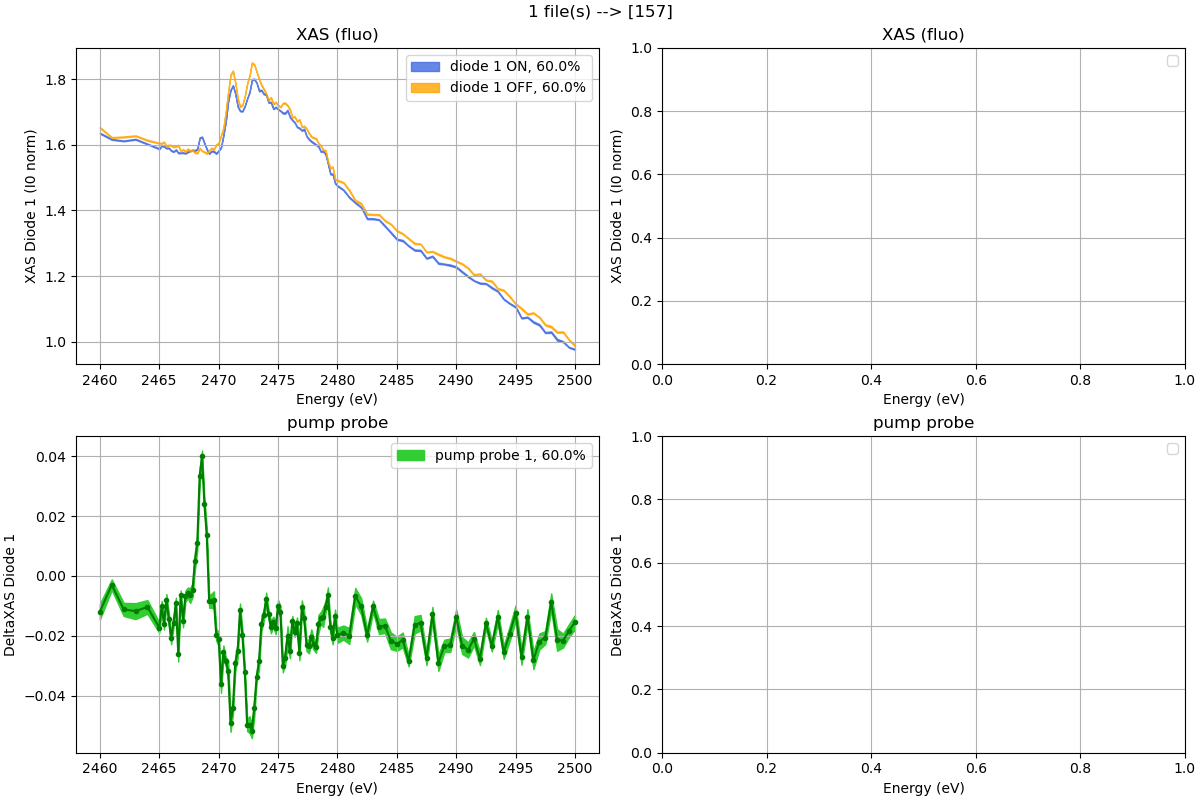

In [48]:
quantile_corr = 0.6

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

ff = glob.glob(Loaddir+'/*{}*/XANES_energy_eV.npy'.format(runlist[0]))
Energy_eV = np.load(ff[0])

ax1.fill_between(Energy_eV, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(Energy_eV, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax3.fill_between(Energy_eV, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax3.plot(Energy_eV, XAS1_pump_probe, color='green', marker='.')
#ax3.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))
try:
    ax2.fill_between(Energy_eV, XAS2_pump - err2_low_pump, XAS2_pump + err2_high_pump , label='diode 2 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
    ax2.fill_between(Energy_eV, XAS2_unpump - err2_low_unpump, XAS2_unpump + err2_high_unpump, label='diode 2 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
    ax4.fill_between(Energy_eV, XAS2_pump_probe - err2_low_pump_probe, XAS2_pump_probe + err2_low_pump_probe, label='pump probe 2, {}%'.format(quantile_corr*100),color='limegreen')
    ax4.plot(Energy_eV, XAS2_pump_probe, color='green', marker='.')
    #ax4.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))
except:
    print ('Diode2 files not found')

ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax3.set_xlabel("Energy (eV)")
ax3.set_ylabel ("DeltaXAS Diode 1")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("XAS Diode 1 (I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax4.set_xlabel("Energy (eV)")
ax4.set_ylabel ("DeltaXAS Diode 1")
ax4.set_title('pump probe')
ax4.legend(loc="best")
ax4.grid()

plt.show()

# Overlay different XANES  spectra
### load data

In [3]:
#runlist = np.arange(246, 249, 1)
runlist = [242, 243]
Loaddir = '../Claudio/Reduced_XANES/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [242, 243] from ../Claudio/Reduced_XANES/


['../Claudio/Reduced_XANES/run0242-Ptdmbipy(SPhCOOCH3)2_energyscan_10ps_3uJ/run_array.npy',
 '../Claudio/Reduced_XANES/run0243-Ptdmbipy(SPhCOOCH3)2_energyscan_10ps_3uJ/run_array.npy']

# TWO DIODES

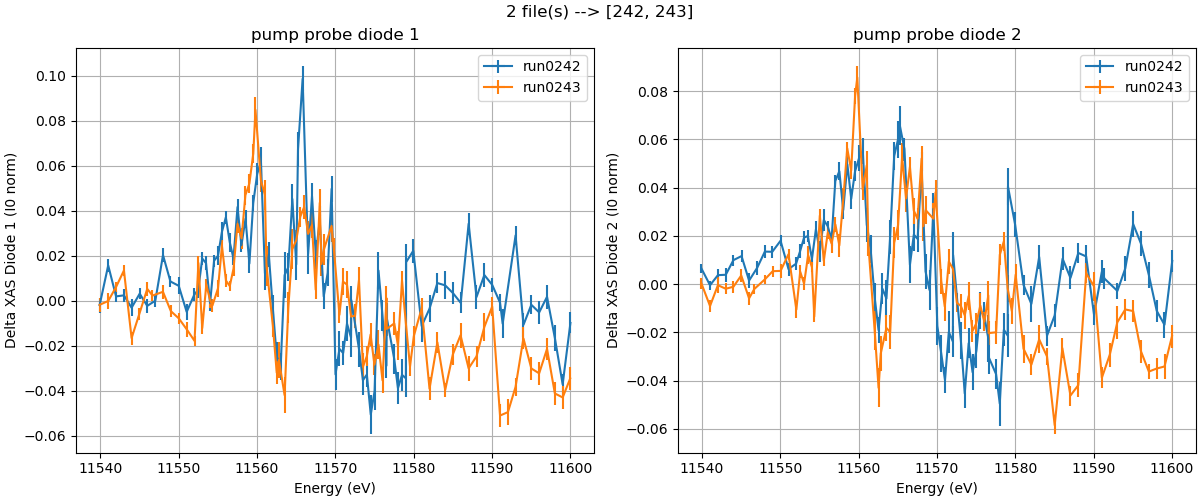

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        
        XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
        D2p = run_array[key]["DataDiode2_pump"]
        D2u = run_array[key]["DataDiode2_unpump"]
        
        gs1 = run_array[key]["goodshots1"]
        gs2 = run_array[key]["goodshots2"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
        err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
        err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
        err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)
        
        err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
        err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
        
        #ax1.plot(Energy_eV, XAS1_pump_probe[:,0])
        #ax2.plot(Energy_eV, XAS2_pump_probe[:,0])
            
        ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        ax2.axes.errorbar(Energy_eV, XAS2_pump_probe[:,0], err2_low_pump_probe, err2_high_pump_probe, label=runnumber)
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode 1')
ax2.set_title('pump probe diode 2')

plt.show()

# ONE diode

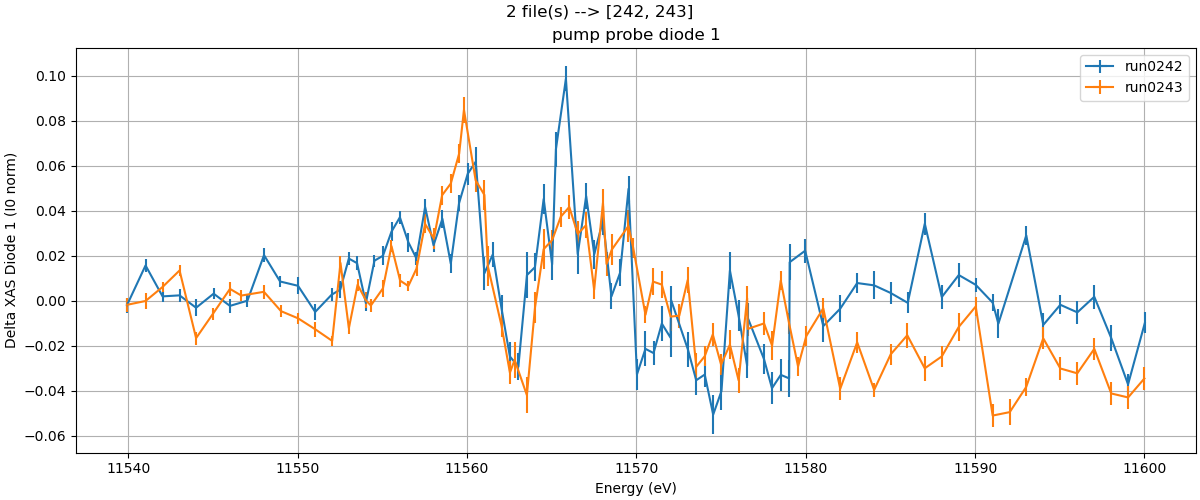

In [65]:
fig, (ax1) = plt.subplots(1, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()


ax1.set_title('pump probe diode 1')

plt.show()